In [ ]:
!pip install -q pillow matplotlib pandas numpy

In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import json
import os
from collections import Counter
import random

plt.style.use('default')
%matplotlib inline

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import json
import os
import numpy as np

class RSICDDataset(Dataset):
    """
    Dataset PyTorch pour RSICD (Remote Sensing Image Captioning Dataset)

    Args:
        images_dir (str): Chemin vers le dossier contenant les images
        annotations_file (str): Chemin vers le fichier JSON des annotations
        split (str): 'train', 'val', 'test', ou None pour tout le dataset
        transform (callable, optional): Transformations à appliquer aux images
    """

    def __init__(self, images_dir, annotations_file, split=None, transform=None):
        self.images_dir = images_dir
        self.transform = transform
        self.split = split

        print("Annotations...")
        with open(annotations_file, 'r', encoding='utf-8') as f:
            annotations = json.load(f)

        if 'images' in annotations:
            self.raw_data = annotations['images']
            print(f"{len(self.raw_data)} images dans le JSON")
        else:
            self.raw_data = annotations if isinstance(annotations, list) else []
            print(f"err: {len(self.raw_data)} entrées")

        self.data = self._organize_data()

        print(f" nb images: {len(self.data)} images")

    def _organize_data(self):
        """
        Organise les annotations dans un format uniforme.
        Filtre par split si spécifié.
        """
        data = []
        missing_images = []

        for item in self.raw_data:
            if self.split and item.get('split') != self.split:
                continue

            filename = item.get('filename', item.get('file_name', item.get('image_name')))

            if not filename:
                continue

            captions = []
            if 'sentences' in item:
                for sent in item['sentences']:
                    if isinstance(sent, dict) and 'raw' in sent:
                        caption = sent['raw'].strip()
                        if caption.endswith(' .'):
                            caption = caption[:-2].strip()
                        elif caption.endswith('.'):
                            caption = caption[:-1].strip()
                        captions.append(caption)
                    elif isinstance(sent, str):
                        captions.append(sent.strip())

            img_path = os.path.join(self.images_dir, filename)

            if os.path.exists(img_path) and len(captions) > 0:
                data.append({
                    'image_name': filename,
                    'image_path': img_path,
                    'captions': captions,
                    'imgid': item.get('imgid', -1),
                    'split': item.get('split', 'unknown')
                })
            else:
                if not os.path.exists(img_path):
                    missing_images.append(filename)

        if missing_images:
            print(f" {len(missing_images)} images non trouvées")
            if len(missing_images) <= 5:
                print(f"      Images manquantes: {missing_images}")
            else:
                print(f"      Premières images manquantes: {missing_images[:5]}")


        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        Retourne un élément du dataset.

        Returns:
            dict: {
                'image': PIL Image ou tensor,
                'captions': list of str,
                'image_name': str,
                'imgid': int,
                'split': str
            }
        """
        item = self.data[idx]

        image = Image.open(item['image_path']).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return {
            'image': image,
            'captions': item['captions'],
            'image_name': item['image_name'],
            'imgid': item['imgid'],
            'split': item['split']
        }

    def get_sample(self, idx=None):
        """
        Récupère un échantillon (utile pour visualisation).
        Si idx=None, retourne un échantillon aléatoire.
        """
        import random
        if idx is None:
            idx = random.randint(0, len(self) - 1)
        return self[idx]

    def get_statistics(self):
        """
        Calcule des statistiques sur le dataset.
        """
        caption_lengths = []
        vocab = set()
        num_captions_per_image = []
        split_counts = {}

        for item in self.data:
            num_captions_per_image.append(len(item['captions']))

            split_name = item['split']
            split_counts[split_name] = split_counts.get(split_name, 0) + 1

            for caption in item['captions']:
                words = caption.lower().split()
                caption_lengths.append(len(words))
                vocab.update(words)

        return {
            'num_images': len(self.data),
            'total_captions': sum(num_captions_per_image),
            'avg_captions_per_image': np.mean(num_captions_per_image),
            'vocab_size': len(vocab),
            'avg_caption_length': np.mean(caption_lengths),
            'min_caption_length': np.min(caption_lengths),
            'max_caption_length': np.max(caption_lengths),
            'std_caption_length': np.std(caption_lengths),
            'split_distribution': split_counts
        }

In [ ]:
IMAGES_DIR = '/content/drive/MyDrive/RSICD_optimal/RSICD_images/RSICD_images'
ANNOTATIONS_FILE = '/content/drive/MyDrive/RSICD_optimal/dataset_rsicd.json'

dataset_full = RSICDDataset(
    images_dir=IMAGES_DIR,
    annotations_file=ANNOTATIONS_FILE,
    split=None,
    transform=None
)

stats = dataset_full.get_statistics()


print(f"\n Distribution par split:")
for split, count in stats['split_distribution'].items():
    percentage = (count / stats['num_images']) * 100
    print(f"   {split:10s}: {count:5d} images ({percentage:5.1f}% )")

Annotations...
10921 images dans le JSON
 nb images: 10921 images

 Distribution par split:
   train     :  8734 images ( 80.0% )
   test      :  1093 images ( 10.0% )
   val       :  1094 images ( 10.0% )


In [ ]:
def visualize_sample(dataset, idx=None, figsize=(14, 8)):
    """
    Visualise une image avec ses captions.

    Args:
        dataset: Instance de RSICDDataset
        idx: Index de l'échantillon (None pour aléatoire)
        figsize: Taille de la figure
    """
    sample = dataset.get_sample(idx)

    fig, ax = plt.subplots(1, 1, figsize=figsize)

    ax.imshow(sample['image'])
    ax.axis('off')

    if idx is None:
        idx = dataset.data.index([item for item in dataset.data if item['image_name'] == sample['image_name']][0])

    plt.suptitle(f"{sample['image_name']} (Index: {idx})",
                 fontsize=16, fontweight='bold', y=0.98)

    captions_text = "\n CAPTIONS:\n\n"
    for i, caption in enumerate(sample['captions'], 1):
        captions_text += f"   {i}. {caption}\n"

    plt.figtext(0.5, 0.02, captions_text,
                ha='center', fontsize=11,
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
                wrap=True)

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.25)
    plt.show()

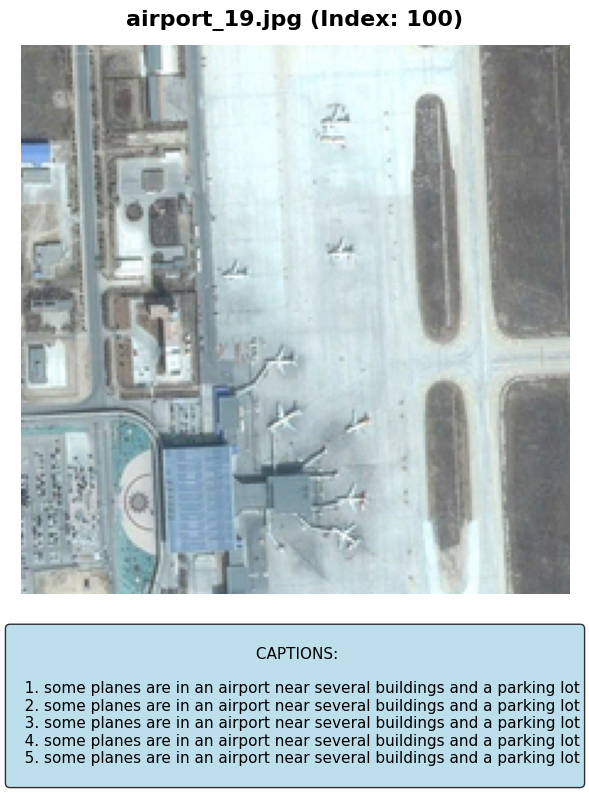

In [ ]:
visualize_sample(dataset_full, idx=100)

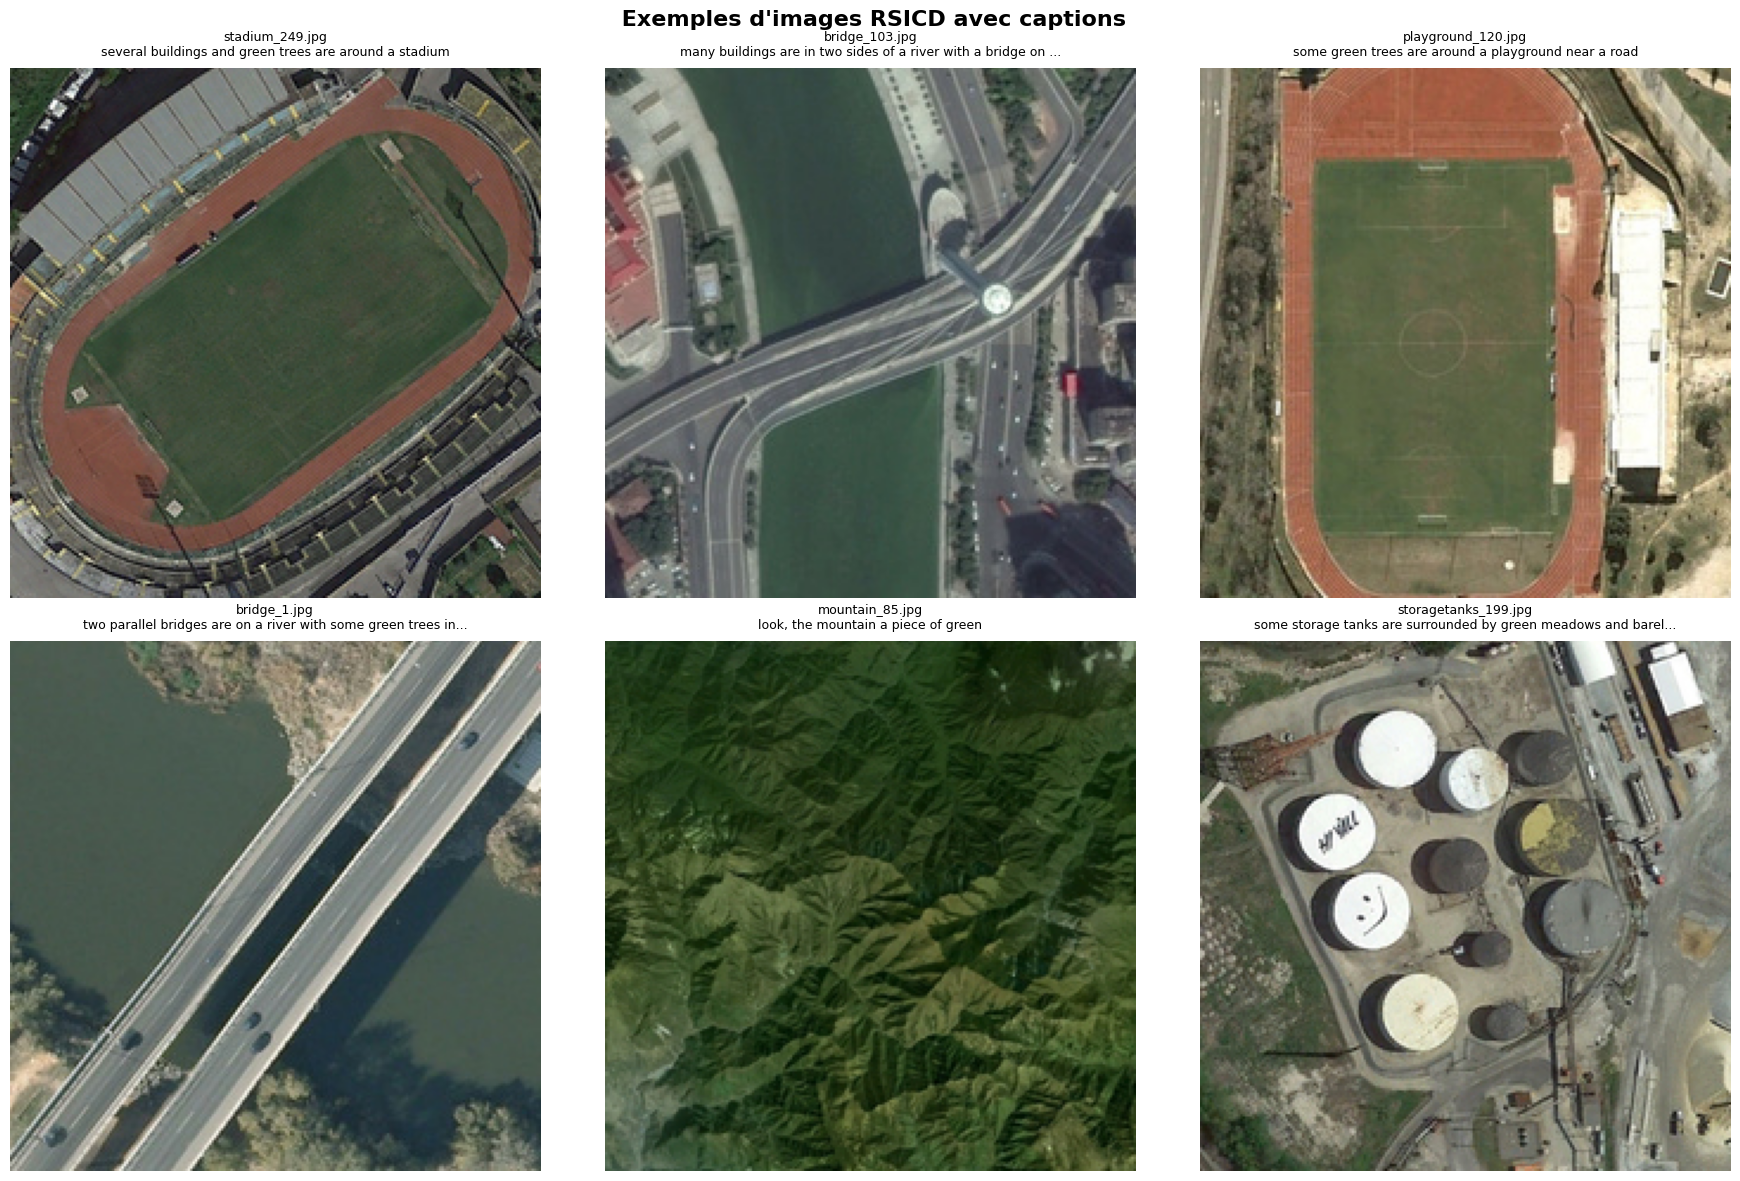

In [ ]:
def visualize_grid(dataset, n_samples=6, figsize=(18, 12)):
    """
    Visualise plusieurs exemples dans une grille.

    Args:
        dataset: Instance de RSICDDataset
        n_samples: Nombre d'exemples à afficher
        figsize: Taille de la figure
    """
    indices = random.sample(range(len(dataset)), n_samples)

    n_cols = 3
    n_rows = (n_samples + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten() if n_samples > 1 else [axes]

    for idx, ax in zip(indices, axes):
        sample = dataset[idx]

        ax.imshow(sample['image'])
        ax.axis('off')

        first_caption = sample['captions'][0]
        if len(first_caption) > 60:
            first_caption = first_caption[:60] + "..."

        title = f"{sample['image_name']}\n{first_caption}"
        ax.set_title(title, fontsize=9, wrap=True, pad=10)

    for ax in axes[len(indices):]:
        ax.axis('off')

    plt.suptitle(" Exemples d'images RSICD avec captions",
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

visualize_grid(dataset_full, n_samples=6)

In [ ]:
def collate_fn(batch):
    """
    Fonction de collate pour gérer les captions de longueurs variables.
    """
    images = [item['image'] for item in batch]
    captions = [item['captions'] for item in batch]
    image_names = [item['image_name'] for item in batch]

    return {
        'images': images,
        'captions': captions,
        'image_names': image_names
    }

dataloader = DataLoader(
    dataset_full,
    batch_size=64,
    shuffle=True,
    collate_fn=collate_fn
)

In [ ]:
class Vocabulary:
    """
    Classe pour gérer le vocabulaire des captions.
    Gère la conversion mots ↔ indices et les tokens spéciaux.
    """

    def __init__(self, freq_threshold=5):
        """
        Args:
            freq_threshold: Fréquence minimale pour qu'un mot soit inclus
        """
        self.freq_threshold = freq_threshold

        self.PAD_TOKEN = "<PAD>"
        self.START_TOKEN = "<START>"
        self.END_TOKEN = "<END>"
        self.UNK_TOKEN = "<UNK>"

        self.word2idx = {}
        self.idx2word = {}
        self.word_freq = {}

        self._init_vocab()

    def _init_vocab(self):
        """Initialise le vocabulaire avec les tokens spéciaux"""
        special_tokens = [self.PAD_TOKEN, self.START_TOKEN, self.END_TOKEN, self.UNK_TOKEN]

        for idx, token in enumerate(special_tokens):
            self.word2idx[token] = idx
            self.idx2word[idx] = token

    def build_vocabulary(self, captions_list):
        """
        Construit le vocabulaire à partir d'une liste de captions.

        Args:
            captions_list: Liste de listes de captions
                          Ex: [[cap1, cap2, ...], [cap3, cap4, ...], ...]
        """
        print("Construction du vocabulaire...")

        for captions in captions_list:
            for caption in captions:
                for word in caption.lower().split():
                    self.word_freq[word] = self.word_freq.get(word, 0) + 1

        idx = len(self.word2idx)  # Commence après les tokens spéciaux

        for word, freq in sorted(self.word_freq.items()):
            if freq >= self.freq_threshold:
                self.word2idx[word] = idx
                self.idx2word[idx] = word
                idx += 1

        print(f"Taille totale: {len(self.word2idx)} mots")
        print(f"Mots avec freq >= {self.freq_threshold}: {len(self.word2idx) - 4}")
        print(f"Mots filtrés (freq < {self.freq_threshold}): {len(self.word_freq) - len(self.word2idx) + 4}")

    def encode(self, caption, add_special_tokens=True):
        """
        Convertit une caption en indices.

        Args:
            caption: String caption
            add_special_tokens: Ajouter <START> et <END>

        Returns:
            Liste d'indices
        """
        tokens = caption.lower().split()

        indices = [
            self.word2idx.get(token, self.word2idx[self.UNK_TOKEN])
            for token in tokens
        ]

        if add_special_tokens:
            indices = [self.word2idx[self.START_TOKEN]] + indices + [self.word2idx[self.END_TOKEN]]

        return indices

    def decode(self, indices, remove_special_tokens=True):
        """
        Convertit des indices en caption.

        Args:
            indices: Liste d'indices ou tensor
            remove_special_tokens: Enlever <START>, <END>, <PAD>

        Returns:
            String caption
        """
        if torch.is_tensor(indices):
            indices = indices.tolist()

        words = [self.idx2word.get(idx, self.UNK_TOKEN) for idx in indices]

        if remove_special_tokens:
            special = {self.PAD_TOKEN, self.START_TOKEN, self.END_TOKEN}
            words = [w for w in words if w not in special]

        return ' '.join(words)

    def __len__(self):
        return len(self.word2idx)

    @property
    def pad_idx(self):
        return self.word2idx[self.PAD_TOKEN]

    @property
    def start_idx(self):
        return self.word2idx[self.START_TOKEN]

    @property
    def end_idx(self):
        return self.word2idx[self.END_TOKEN]

    @property
    def unk_idx(self):
        return self.word2idx[self.UNK_TOKEN]

In [ ]:
train_captions = [
    item['captions']
    for item in dataset_full.data
    if item['split'] == 'train'
]

print(f"Nombre total de captions: {sum(len(caps) for caps in train_captions)}")

vocab = Vocabulary(freq_threshold=3)
vocab.build_vocabulary(train_captions)

print("\nTest d'encodage/décodage:")
test_caption = "many planes are parked next to a long building"
print(f"   Original: '{test_caption}'")

encoded = vocab.encode(test_caption)
print(f"   Encodé:   {encoded}")

decoded = vocab.decode(encoded)
print(f"   Décodé:   '{decoded}'")

Nombre total de captions: 43670
Construction du vocabulaire...
Taille totale: 1434 mots
Mots avec freq >= 3: 1430
Mots filtrés (freq < 3): 1172

Test d'encodage/décodage:
   Original: 'many planes are parked next to a long building'
   Encodé:   [1, 708, 874, 57, 820, 757, 1263, 10, 681, 171, 2]
   Décodé:   'many planes are parked next to a long building'


In [ ]:
from torchvision import transforms

IMG_SIZE = 256

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize directement à 224x224
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [ ]:
class RSICDDatasetWithTokenization(Dataset):
    """
    Dataset RSICD avec tokenization des captions.
    Hérite du dataset original mais retourne des captions tokenizées.
    """

    def __init__(self, base_dataset, vocab, transform=None, max_length=None):
        """
        Args:
            base_dataset: Instance de RSICDDataset
            vocab: Instance de Vocabulary
            transform: Transformations d'images
            max_length: Longueur maximale des captions (None = auto)
        """
        self.base_dataset = base_dataset
        self.vocab = vocab
        self.transform = transform

        if max_length is None:
            all_lengths = []
            for item in base_dataset.data:
                for caption in item['captions']:
                    all_lengths.append(len(caption.split()) + 2)
            self.max_length = max(all_lengths)
        else:
            self.max_length = max_length

        print(f"   Max length: {self.max_length} tokens")

    def __len__(self):
        return len(self.base_dataset)

    def __getitem__(self, idx):
        item = self.base_dataset[idx]

        image = item['image']
        if self.transform:
            image = self.transform(image)

        caption = random.choice(item['captions'])
        caption_tokens = self.vocab.encode(caption, add_special_tokens=True)
        caption_tensor = torch.zeros(self.max_length, dtype=torch.long)
        caption_tensor[:len(caption_tokens)] = torch.tensor(caption_tokens)
        caption_mask = torch.zeros(self.max_length, dtype=torch.bool)
        caption_mask[:len(caption_tokens)] = True

        return {
            'image': image,
            'caption': caption_tensor,
            'caption_mask': caption_mask,
            'caption_length': len(caption_tokens),
            'image_name': item['image_name'],
            'all_captions': item['captions']
        }

In [ ]:
dataset_train = RSICDDataset(
    images_dir=IMAGES_DIR,
    annotations_file=ANNOTATIONS_FILE,
    split='train',
    transform=None  # On appliquera les transforms dans le wrapper
)

dataset_train_tokenized = RSICDDatasetWithTokenization(
    base_dataset=dataset_train,
    vocab=vocab,
    transform=train_transform
)

print(f"Train dataset: {len(dataset_train_tokenized)} images")

Annotations...
10921 images dans le JSON
 nb images: 8734 images
   Max length: 36 tokens
Train dataset: 8734 images


In [ ]:
dataset_val = RSICDDataset(
    images_dir=IMAGES_DIR,
    annotations_file=ANNOTATIONS_FILE,
    split='val',
    transform=None
)

dataset_val_tokenized = RSICDDatasetWithTokenization(
    base_dataset=dataset_val,
    vocab=vocab,
    transform=val_test_transform
)

print(f"Val dataset: {len(dataset_val_tokenized)} images")

Annotations...
10921 images dans le JSON
 nb images: 1094 images
   Max length: 28 tokens
Val dataset: 1094 images


In [ ]:
dataset_test = RSICDDataset(
    images_dir=IMAGES_DIR,
    annotations_file=ANNOTATIONS_FILE,
    split='test',
    transform=None
)

dataset_test_tokenized = RSICDDatasetWithTokenization(
    base_dataset=dataset_test,
    vocab=vocab,
    transform=val_test_transform
)

print(f"Test dataset: {len(dataset_test_tokenized)} images")

Annotations...
10921 images dans le JSON
 nb images: 1093 images
   Max length: 34 tokens
Test dataset: 1093 images


In [ ]:
def collate_fn_with_padding(batch):
    """
    Fonction de collate pour créer des batches avec padding.
    """
    batch = sorted(batch, key=lambda x: x['caption_length'], reverse=True)

    images = torch.stack([item['image'] for item in batch])

    captions = torch.stack([item['caption'] for item in batch])

    caption_masks = torch.stack([item['caption_mask'] for item in batch])

    caption_lengths = torch.tensor([item['caption_length'] for item in batch])

    image_names = [item['image_name'] for item in batch]
    all_captions = [item['all_captions'] for item in batch]

    return {
        'images': images,
        'captions': captions,
        'caption_masks': caption_masks,
        'caption_lengths': caption_lengths,
        'image_names': image_names,
        'all_captions': all_captions
    }

In [ ]:
BATCH_SIZE_TRAIN = 64
BATCH_SIZE_VAL = 128
BATCH_SIZE_TEST = 1
NUM_WORKERS = 2
PIN_MEMORY = True

train_loader = DataLoader(
    dataset_train_tokenized,
    batch_size=BATCH_SIZE_TRAIN,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    collate_fn=collate_fn_with_padding,
    drop_last=True
)

val_loader = DataLoader(
    dataset_val_tokenized,
    batch_size=BATCH_SIZE_VAL,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    collate_fn=collate_fn_with_padding
)

test_loader = DataLoader(
    dataset_test_tokenized,
    batch_size=BATCH_SIZE_TEST,
    shuffle=False,
    collate_fn=collate_fn_with_padding
)

In [ ]:
import pickle

vocab_save_path = '/content/drive/MyDrive/RSICD_optimal/vocab.pkl'

with open(vocab_save_path, 'wb') as f:
    pickle.dump(vocab, f)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
import numpy as np
from tqdm import tqdm
import time
import matplotlib.pyplot as plt
import math

if torch.cuda.is_available():
    print(f" Device: {torch.cuda.get_device_name(0)}")

 Device: Tesla T4


In [ ]:
class EncoderCNN(nn.Module):
    """
    Encoder CNN basé sur ResNet-50 pré-entraîné.
    Extrait les features visuelles d'une image.
    """

    def __init__(self, embed_size):
        """
        Args:
            embed_size: Dimension de l'embedding (ex: 256)
        """
        super(EncoderCNN, self).__init__()

        resnet = models.resnet50(pretrained=True)

        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(2048, embed_size)
        self.bn = nn.BatchNorm1d(embed_size)

        self.fine_tune(fine_tune=True)

    def forward(self, images):
        """
        Forward pass.

        Args:
            images: [batch_size, 3, 224, 224]

        Returns:
            features: [batch_size, embed_size]
        """
        with torch.no_grad():
            features = self.resnet(images)

        features = self.adaptive_pool(features)
        features = features.view(features.size(0), -1)

        features = self.fc(features)
        features = self.bn(features)

        return features

    def fine_tune(self, fine_tune=True):
        """
        Permet le fine-tuning des couches ResNet.

        Args:
            fine_tune: Si True, permet le gradient pour les dernières couches
        """
        for param in self.resnet.parameters():
            param.requires_grad = False

        if fine_tune:
            for module in list(self.resnet.children())[-2:]:
                for param in module.parameters():
                    param.requires_grad = True

In [ ]:
#!Changement: Nouvelle classe PositionalEncoding pour le Transformer
class PositionalEncoding(nn.Module):
    """
    Implémente le positional encoding pour le Transformer.
    Ajoute des informations de position aux embeddings des mots.
    """

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        """
        Args:
            d_model: Dimension des embeddings
            dropout: Taux de dropout
            max_len: Longueur maximale des séquences
        """
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Créer la matrice de positional encoding
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)  # [1, max_len, d_model]
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: [batch_size, seq_len, d_model]
        Returns:
            x avec positional encoding: [batch_size, seq_len, d_model]
        """
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

In [ ]:
#!Changement: Nouvelle classe DecoderTransformer qui remplace DecoderLSTM
class DecoderTransformer(nn.Module):
    """
    Decoder Transformer pour la génération de captions.
    Remplace le décodeur LSTM par une architecture Transformer.
    """

    def __init__(self, embed_dim, decoder_dim, vocab_size, num_heads=8,
                 num_layers=6, encoder_dim=256, dropout=0.1, max_length=100):
        """
        Args:
            embed_dim: Dimension des word embeddings
            decoder_dim: Dimension du modèle Transformer (doit être divisible par num_heads)
            vocab_size: Taille du vocabulaire
            num_heads: Nombre de têtes d'attention
            num_layers: Nombre de couches Transformer
            encoder_dim: Dimension des features encoder
            dropout: Taux de dropout
            max_length: Longueur maximale des séquences
        """
        super(DecoderTransformer, self).__init__()

        self.encoder_dim = encoder_dim
        self.embed_dim = embed_dim
        self.decoder_dim = decoder_dim
        self.vocab_size = vocab_size
        self.dropout = dropout

        self.embedding = nn.Embedding(vocab_size, embed_dim)

        self.pos_encoder = PositionalEncoding(embed_dim, dropout, max_length)

        self.image_projection = nn.Linear(encoder_dim, embed_dim)

        if embed_dim != decoder_dim:
            self.embed_projection = nn.Linear(embed_dim, decoder_dim)
        else:
            self.embed_projection = nn.Identity()

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=decoder_dim,
            nhead=num_heads,
            dim_feedforward=decoder_dim * 4,
            dropout=dropout,
            activation='relu',
            batch_first=True
        )

        self.transformer_decoder = nn.TransformerDecoder(
            decoder_layer,
            num_layers=num_layers
        )


        self.fc_out = nn.Linear(decoder_dim, vocab_size)

        self.dropout_layer = nn.Dropout(dropout)

        self._init_weights()

    def _init_weights(self):
        """Initialise les poids du modèle"""
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc_out.bias.data.zero_()
        self.fc_out.weight.data.uniform_(-initrange, initrange)

    def generate_square_subsequent_mask(self, sz, device):
        """
        Génère un masque causal pour empêcher le modèle de voir les tokens futurs.

        Args:
            sz: Taille de la séquence
            device: Device
        Returns:
            mask: [sz, sz]
        """
        mask = torch.triu(torch.ones(sz, sz, device=device), diagonal=1)
        mask = mask.masked_fill(mask == 1, float('-inf'))
        return mask

    def forward(self, encoder_out, captions, caption_lengths):
        """
        Forward pass du Transformer decoder.

        Args:
            encoder_out: Features de l'image [batch_size, encoder_dim]
            captions: Captions tokenizées [batch_size, max_length]
            caption_lengths: Longueurs réelles [batch_size]

        Returns:
            predictions: [batch_size, max_length, vocab_size]
            None (pour compatibilité avec l'ancien code, pas d'alphas pour Transformer)
        """
        batch_size = encoder_out.size(0)
        max_length = captions.size(1)
        device = encoder_out.device

        encoder_out = self.image_projection(encoder_out)

        memory = encoder_out.unsqueeze(1)

        if self.embed_dim != self.decoder_dim:
            memory = self.embed_projection(memory)

        tgt_embeddings = self.embedding(captions)
        tgt_embeddings = self.pos_encoder(tgt_embeddings)

        tgt = self.embed_projection(tgt_embeddings)

        tgt_mask = self.generate_square_subsequent_mask(max_length, device)

        tgt_key_padding_mask = torch.zeros(batch_size, max_length, dtype=torch.bool, device=device)
        for i, length in enumerate(caption_lengths):
            if length < max_length:
                tgt_key_padding_mask[i, length:] = True

        output = self.transformer_decoder(
            tgt=tgt,
            memory=memory,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_key_padding_mask
        )

        output = self.dropout_layer(output)
        predictions = self.fc_out(output)

        return predictions, None

In [ ]:
#!Changement:
class ImageCaptioningModel(nn.Module):
    """
    Modèle complet Encoder-Decoder pour Image Captioning avec Transformer.
    """

    def __init__(self, embed_size, decoder_dim, vocab_size, num_heads=8,
                 num_layers=6, encoder_dim=256, dropout=0.1, max_length=100):
        super(ImageCaptioningModel, self).__init__()

        self.encoder = EncoderCNN(embed_size=encoder_dim)
        self.decoder = DecoderTransformer(
            embed_dim=embed_size,
            decoder_dim=decoder_dim,
            vocab_size=vocab_size,
            num_heads=num_heads,
            num_layers=num_layers,
            encoder_dim=encoder_dim,
            dropout=dropout,
            max_length=max_length
        )

    def forward(self, images, captions, caption_lengths):
        """
        Forward pass.

        Args:
            images: [batch_size, 3, 224, 224]
            captions: [batch_size, max_length]
            caption_lengths: [batch_size]

        Returns:
            predictions: [batch_size, max_length, vocab_size]
            alphas: None (pas d'attention à visualiser pour Transformer)
        """
        # Encoder
        encoder_out = self.encoder(images)

        # Decoder
        predictions, alphas = self.decoder(encoder_out, captions, caption_lengths)

        return predictions, alphas

In [ ]:
EMBED_SIZE = 256
DECODER_DIM = 512
NUM_HEADS = 8
NUM_LAYERS = 6
ENCODER_DIM = 256
DROPOUT = 0.1
VOCAB_SIZE = len(vocab)
MAX_LENGTH = 50

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = ImageCaptioningModel(
    embed_size=EMBED_SIZE,
    decoder_dim=DECODER_DIM,
    vocab_size=VOCAB_SIZE,
    num_heads=NUM_HEADS,
    num_layers=NUM_LAYERS,
    encoder_dim=ENCODER_DIM,
    dropout=DROPOUT,
    max_length=MAX_LENGTH
).to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n Paramètres du modèle:")
print(f"   Total:        {total_params:,}")
print(f"   Entraînables: {trainable_params:,}")
print(f"   Gelés:        {total_params - trainable_params:,}")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



 Paramètres du modèle:
   Total:        50,557,402
   Entraînables: 49,112,474
   Gelés:        1,444,928


In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=vocab.pad_idx)

encoder_lr = 1e-4
decoder_lr = 4e-4

optimizer = optim.Adam([
    {'params': filter(lambda p: p.requires_grad, model.encoder.parameters()),
     'lr': encoder_lr},
    {'params': model.decoder.parameters(),
     'lr': decoder_lr}
])

scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3
)

In [ ]:
#!Changement
def generate_caption_greedy(model, image, vocab, max_length=50, device='cuda'):
    """
    Génère une caption avec greedy search pour le modèle Transformer.

    Args:
        model: Modèle entraîné
        image: Image tensor [1, 3, 224, 224]
        vocab: Objet Vocabulary
        max_length: Longueur maximale
        device: Device

    Returns:
        caption: Caption générée (string)
        alphas: None (pas d'alphas pour Transformer)
    """
    model.eval()

    with torch.no_grad():
        image = image.to(device)
        encoder_out = model.encoder(image)

        encoder_out_proj = model.decoder.image_projection(encoder_out)
        memory = encoder_out_proj.unsqueeze(1)

        if model.decoder.embed_dim != model.decoder.decoder_dim:
            memory = model.decoder.embed_projection(memory)

        caption_indices = [vocab.start_idx]

        for t in range(max_length):
            tgt_tokens = torch.tensor([caption_indices], device=device)

            tgt_embeddings = model.decoder.embedding(tgt_tokens)
            tgt_embeddings = model.decoder.pos_encoder(tgt_embeddings)
            tgt = model.decoder.embed_projection(tgt_embeddings)

            tgt_mask = model.decoder.generate_square_subsequent_mask(len(caption_indices), device)

            output = model.decoder.transformer_decoder(
                tgt=tgt,
                memory=memory,
                tgt_mask=tgt_mask
            )

            scores = model.decoder.fc_out(output[:, -1, :])
            word_idx = scores.argmax(dim=1).item()

            caption_indices.append(word_idx)

            if word_idx == vocab.end_idx:
                break

        caption = vocab.decode(caption_indices, remove_special_tokens=True)

    return caption, None

In [ ]:
#!Changement:
def generate_caption_beam_search(model, image, vocab, beam_width=3, max_length=50, device='cuda'):
    """
    Génère une caption avec beam search pour le modèle Transformer.

    Args:
        model: Modèle entraîné
        image: Image tensor [1, 3, 224, 224]
        vocab: Objet Vocabulary
        beam_width: Largeur du beam
        max_length: Longueur maximale
        device: Device

    Returns:
        caption: Meilleure caption (string)
    """
    model.eval()

    with torch.no_grad():
        image = image.to(device)
        encoder_out = model.encoder(image)

        encoder_out_proj = model.decoder.image_projection(encoder_out)
        memory = encoder_out_proj.unsqueeze(1)

        if model.decoder.embed_dim != model.decoder.decoder_dim:
            memory = model.decoder.embed_projection(memory)

        memory = memory.expand(beam_width, -1, -1)


        beams = [
            ([vocab.start_idx], 0.0)
            for _ in range(beam_width)
        ]

        complete_seqs = []
        complete_scores = []

        for t in range(max_length):
            all_candidates = []

            for beam_idx, (seq, score) in enumerate(beams):
                if seq[-1] == vocab.end_idx:
                    complete_seqs.append(seq)
                    complete_scores.append(score)
                    continue

                tgt_tokens = torch.tensor([seq], device=device)

                tgt_embeddings = model.decoder.embedding(tgt_tokens)
                tgt_embeddings = model.decoder.pos_encoder(tgt_embeddings)
                tgt = model.decoder.embed_projection(tgt_embeddings)

                tgt_mask = model.decoder.generate_square_subsequent_mask(len(seq), device)

                output = model.decoder.transformer_decoder(
                    tgt=tgt,
                    memory=memory[beam_idx:beam_idx+1],
                    tgt_mask=tgt_mask
                )

                scores_logits = model.decoder.fc_out(output[:, -1, :])
                log_probs = F.log_softmax(scores_logits, dim=1)

                top_log_probs, top_indices = log_probs.topk(beam_width, dim=1)

                for k in range(beam_width):
                    word_id = top_indices[0, k].item()
                    word_log_prob = top_log_probs[0, k].item()

                    new_seq = seq + [word_id]
                    new_score = score + word_log_prob

                    all_candidates.append((new_seq, new_score))

            if all_candidates:
                all_candidates.sort(key=lambda x: x[1], reverse=True)
                beams = all_candidates[:beam_width]

            if not beams:
                break
        if not complete_seqs and beams:
            complete_seqs.extend([seq for seq, _ in beams])
            complete_scores.extend([score for _, score in beams])

        if complete_seqs:
            best_idx = complete_scores.index(max(complete_scores))
            best_seq = complete_seqs[best_idx]
        else:
            best_seq = [vocab.start_idx, vocab.end_idx]

        caption = vocab.decode(best_seq, remove_special_tokens=True)

    return caption

In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer, device, epoch):
    """
    Entraîne le modèle pendant une epoch.
    """
    model.train()

    running_loss = 0.0
    num_batches = len(train_loader)

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}")

    for batch_idx, batch in enumerate(pbar):
        images = batch['images'].to(device)
        captions = batch['captions'].to(device)
        caption_lengths = batch['caption_lengths'].to(device)

        predictions, alphas = model(images, captions, caption_lengths)

        targets = captions[:, 1:]
        predictions = predictions[:, :-1, :]

        predictions = predictions.reshape(-1, VOCAB_SIZE)
        targets = targets.reshape(-1)

        loss = criterion(predictions, targets)

        optimizer.zero_grad()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)

        optimizer.step()

        running_loss += loss.item()

        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    epoch_loss = running_loss / num_batches

    return epoch_loss

In [ ]:
def validate(model, val_loader, criterion, device):
    """
    Évalue le modèle sur le dataset de validation.
    """
    model.eval()

    running_loss = 0.0
    num_batches = len(val_loader)

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            images = batch['images'].to(device)
            captions = batch['captions'].to(device)
            caption_lengths = batch['caption_lengths'].to(device)

            predictions, alphas = model(images, captions, caption_lengths)

            targets = captions[:, 1:]
            predictions = predictions[:, :-1, :]

            predictions = predictions.reshape(-1, VOCAB_SIZE)
            targets = targets.reshape(-1)

            loss = criterion(predictions, targets)
            running_loss += loss.item()

    val_loss = running_loss / num_batches

    return val_loss


In [ ]:
NUM_EPOCHS = 50
SAVE_DIR = '/content/drive/MyDrive/RSICD_optimal/checkpoints'
BEST_MODEL_PATH = '/content/drive/MyDrive/RSICD_optimal/best_model.pth'

import os
os.makedirs(SAVE_DIR, exist_ok=True)

train_losses = []
val_losses = []
best_val_loss = float('inf')

start_time = time.time()

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\nEPOCH {epoch}/{NUM_EPOCHS}")

    # Temporarily disable anomaly detection to proceed with the fix
    # This is a good practice for debugging, but the actual fix avoids this need
    # with torch.autograd.set_detect_anomaly(True):
    train_loss = train_one_epoch(
        model, train_loader, criterion, optimizer, device, epoch
    )
    train_losses.append(train_loss)

    val_loss = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    print(f"   Train Loss: {train_loss:.4f}")
    print(f"   Val Loss:   {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'vocab': vocab
        }, BEST_MODEL_PATH)
        print(f" Meilleur modèle sauvegardé! (Val Loss: {val_loss:.4f})")

    if epoch % 5 == 0:
        checkpoint_path = os.path.join(SAVE_DIR, f'checkpoint_epoch_{epoch}.pth')
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
        }, checkpoint_path)
        print(f" Checkpoint sauvegardé: epoch_{epoch}.pth")

total_time = time.time() - start_time
print(f"Temps total: {total_time/60:.2f} minutes")
print(f"Meilleure Val Loss: {best_val_loss:.4f}")


EPOCH 1/50


Epoch 1:   0%|          | 0/136 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6044: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
Validation: 100%|██████████| 9/9 [07:41<00:00, 51.24s/it]


   Train Loss: 4.3069
   Val Loss:   3.8539
 Meilleur modèle sauvegardé! (Val Loss: 3.8539)

EPOCH 2/50


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


   Train Loss: 3.5793
   Val Loss:   3.2976
 Meilleur modèle sauvegardé! (Val Loss: 3.2976)

EPOCH 3/50


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]


   Train Loss: 3.0598
   Val Loss:   2.9638
 Meilleur modèle sauvegardé! (Val Loss: 2.9638)

EPOCH 4/50


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.36it/s]


   Train Loss: 2.5513
   Val Loss:   2.5514
 Meilleur modèle sauvegardé! (Val Loss: 2.5514)

EPOCH 5/50


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]


   Train Loss: 2.2179
   Val Loss:   2.4126
 Meilleur modèle sauvegardé! (Val Loss: 2.4126)
 Checkpoint sauvegardé: epoch_5.pth

EPOCH 6/50


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.15it/s]


   Train Loss: 1.9808
   Val Loss:   2.2490
 Meilleur modèle sauvegardé! (Val Loss: 2.2490)

EPOCH 7/50


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


   Train Loss: 1.8403
   Val Loss:   2.2289
 Meilleur modèle sauvegardé! (Val Loss: 2.2289)

EPOCH 8/50


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


   Train Loss: 1.7419
   Val Loss:   2.2308

EPOCH 9/50


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.34it/s]


   Train Loss: 1.6665
   Val Loss:   2.1099
 Meilleur modèle sauvegardé! (Val Loss: 2.1099)

EPOCH 10/50


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]


   Train Loss: 1.6078
   Val Loss:   2.1681
 Checkpoint sauvegardé: epoch_10.pth

EPOCH 11/50


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]


   Train Loss: 1.5455
   Val Loss:   2.0783
 Meilleur modèle sauvegardé! (Val Loss: 2.0783)

EPOCH 12/50


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.37it/s]


   Train Loss: 1.5099
   Val Loss:   2.0825

EPOCH 13/50


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


   Train Loss: 1.4616
   Val Loss:   2.0362
 Meilleur modèle sauvegardé! (Val Loss: 2.0362)

EPOCH 14/50


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.20it/s]


   Train Loss: 1.4255
   Val Loss:   2.1281

EPOCH 15/50


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.36it/s]


   Train Loss: 1.3944
   Val Loss:   2.0998
 Checkpoint sauvegardé: epoch_15.pth

EPOCH 16/50


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


   Train Loss: 1.3690
   Val Loss:   2.2036

EPOCH 17/50


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.31it/s]


   Train Loss: 1.3382
   Val Loss:   2.1274

EPOCH 18/50


Validation: 100%|██████████| 9/9 [00:05<00:00,  1.50it/s]


   Train Loss: 1.2352
   Val Loss:   2.1431

EPOCH 19/50


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.14it/s]


   Train Loss: 1.1852
   Val Loss:   2.0906

EPOCH 20/50


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


   Train Loss: 1.1364
   Val Loss:   2.0856
 Checkpoint sauvegardé: epoch_20.pth

EPOCH 21/50


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]


   Train Loss: 1.1311
   Val Loss:   2.0858

EPOCH 22/50


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.44it/s]


   Train Loss: 1.0845
   Val Loss:   2.0429

EPOCH 23/50


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.28it/s]


   Train Loss: 1.0434
   Val Loss:   2.0451

EPOCH 24/50


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.25it/s]


   Train Loss: 1.0206
   Val Loss:   1.9935
 Meilleur modèle sauvegardé! (Val Loss: 1.9935)

EPOCH 25/50


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]


   Train Loss: 1.0050
   Val Loss:   2.2011
 Checkpoint sauvegardé: epoch_25.pth

EPOCH 26/50


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]


   Train Loss: 1.0002
   Val Loss:   2.0546

EPOCH 27/50


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.42it/s]


   Train Loss: 0.9861
   Val Loss:   2.1524

EPOCH 28/50


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


   Train Loss: 0.9775
   Val Loss:   2.1422

EPOCH 29/50


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.34it/s]


   Train Loss: 0.9350
   Val Loss:   2.1143

EPOCH 30/50


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.33it/s]


   Train Loss: 0.9234
   Val Loss:   2.1855
 Checkpoint sauvegardé: epoch_30.pth

EPOCH 31/50


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.46it/s]


   Train Loss: 0.9161
   Val Loss:   2.1651

EPOCH 32/50


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.13it/s]


   Train Loss: 0.9085
   Val Loss:   2.1592

EPOCH 33/50


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]


   Train Loss: 0.8780
   Val Loss:   2.0470

EPOCH 34/50


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.40it/s]


   Train Loss: 0.8952
   Val Loss:   2.2415

EPOCH 35/50


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.18it/s]


   Train Loss: 0.8847
   Val Loss:   2.0728
 Checkpoint sauvegardé: epoch_35.pth

EPOCH 36/50


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


   Train Loss: 0.8792
   Val Loss:   2.1167

EPOCH 37/50


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]


   Train Loss: 0.8650
   Val Loss:   2.0918

EPOCH 38/50


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.38it/s]


   Train Loss: 0.8568
   Val Loss:   2.1128

EPOCH 39/50


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.17it/s]


   Train Loss: 0.8621
   Val Loss:   2.0963

EPOCH 40/50


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.33it/s]


   Train Loss: 0.8649
   Val Loss:   2.2375
 Checkpoint sauvegardé: epoch_40.pth

EPOCH 41/50


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.39it/s]


   Train Loss: 0.8529
   Val Loss:   2.1531

EPOCH 42/50


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.28it/s]


   Train Loss: 0.8612
   Val Loss:   2.1263

EPOCH 43/50


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.21it/s]


   Train Loss: 0.8607
   Val Loss:   2.1542

EPOCH 44/50


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.30it/s]


   Train Loss: 0.8453
   Val Loss:   2.1101

EPOCH 45/50


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.37it/s]


   Train Loss: 0.8497
   Val Loss:   2.1307
 Checkpoint sauvegardé: epoch_45.pth

EPOCH 46/50


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.33it/s]


   Train Loss: 0.8357
   Val Loss:   2.1272

EPOCH 47/50


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]


   Train Loss: 0.8389
   Val Loss:   2.0884

EPOCH 48/50


Validation: 100%|██████████| 9/9 [00:06<00:00,  1.41it/s]


   Train Loss: 0.8484
   Val Loss:   2.0757

EPOCH 49/50


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.19it/s]


   Train Loss: 0.8551
   Val Loss:   2.1248

EPOCH 50/50


Validation: 100%|██████████| 9/9 [00:07<00:00,  1.27it/s]


   Train Loss: 0.8522
   Val Loss:   2.2045
 Checkpoint sauvegardé: epoch_50.pth
Temps total: 122.67 minutes
Meilleure Val Loss: 1.9935


In [ ]:
def plot_training_curves(train_losses, val_losses):
    """
    Visualise les courbes d'apprentissage.
    """
    plt.figure(figsize=(12, 5))

    # Loss curves
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss', marker='o')
    plt.plot(val_losses, label='Val Loss', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/RSICD_optimal/training_curves.png', dpi=150)
    plt.show()

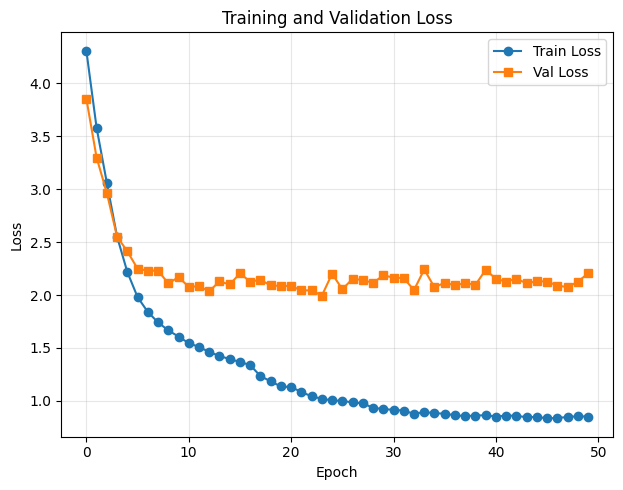

In [ ]:
plot_training_curves(train_losses, val_losses)

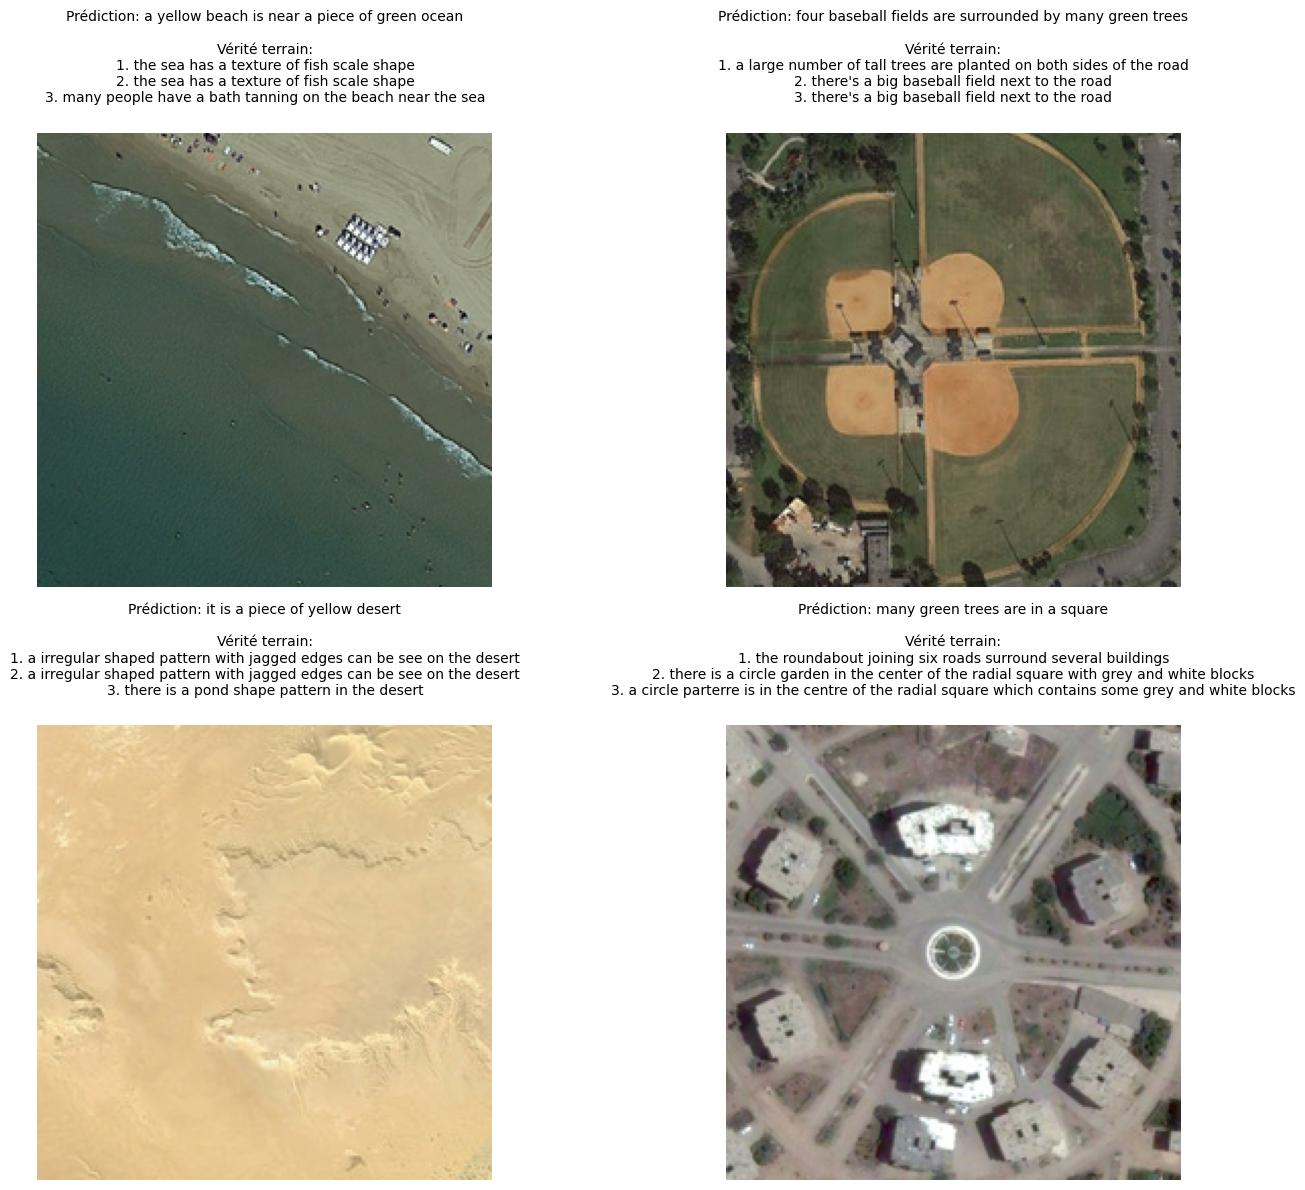

In [ ]:
import random
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

def generate_caption_greedy(model, image, vocab, max_length=50, device='cuda'):
    """
    Génère une caption avec greedy search pour le modèle Transformer.

    Args:
        model: Modèle entraîné
        image: Image tensor [1, 3, 224, 224]
        vocab: Objet Vocabulary
        max_length: Longueur maximale
        device: Device

    Returns:
        caption: Caption générée (string)
        alphas: None (pas d'alphas pour Transformer)
    """
    model.eval()

    with torch.no_grad():
        image = image.to(device)
        encoder_out = model.encoder(image)

        encoder_out_proj = model.decoder.image_projection(encoder_out)
        memory = encoder_out_proj.unsqueeze(1)

        if model.decoder.embed_dim != model.decoder.decoder_dim:
            memory = model.decoder.embed_projection(memory)

        caption_indices = [vocab.start_idx]

        for t in range(max_length):
            tgt_tokens = torch.tensor([caption_indices], device=device)
            tgt_embeddings = model.decoder.embedding(tgt_tokens)
            tgt_embeddings = model.decoder.pos_encoder(tgt_embeddings)
            tgt = model.decoder.embed_projection(tgt_embeddings)

            tgt_mask = model.decoder.generate_square_subsequent_mask(len(caption_indices), device)

            output = model.decoder.transformer_decoder(
                tgt=tgt,
                memory=memory,
                tgt_mask=tgt_mask
            )
            scores = model.decoder.fc_out(output[:, -1, :])
            word_idx = scores.argmax(dim=1).item()

            caption_indices.append(word_idx)

            if word_idx == vocab.end_idx:
                break

        caption = vocab.decode(caption_indices, remove_special_tokens=True)

    return caption, None

def generate_caption_beam_search(model, image, vocab, beam_width=3, max_length=50, device='cuda'):
    """
    Génère une caption avec beam search pour le modèle Transformer.

    Args:
        model: Modèle entraîné
        image: Image tensor [1, 3, 224, 224]
        vocab: Objet Vocabulary
        beam_width: Largeur du beam
        max_length: Longueur maximale
        device: Device

    Returns:
        caption: Meilleure caption (string)
    """
    model.eval()

    with torch.no_grad():
        image = image.to(device)
        encoder_out = model.encoder(image)

        encoder_out_proj = model.decoder.image_projection(encoder_out)
        memory = encoder_out_proj.unsqueeze(1)

        if model.decoder.embed_dim != model.decoder.decoder_dim:
            memory = model.decoder.embed_projection(memory)

        memory = memory.expand(beam_width, -1, -1)

        beams = [
            ([vocab.start_idx], 0.0)
            for _ in range(beam_width)
        ]

        complete_seqs = []
        complete_scores = []

        for t in range(max_length):
            all_candidates = []

            for beam_idx, (seq, score) in enumerate(beams):
                if seq[-1] == vocab.end_idx:
                    complete_seqs.append(seq)
                    complete_scores.append(score)
                    continue

                tgt_tokens = torch.tensor([seq], device=device)

                tgt_embeddings = model.decoder.embedding(tgt_tokens)
                tgt_embeddings = model.decoder.pos_encoder(tgt_embeddings)
                tgt = model.decoder.embed_projection(tgt_embeddings)

                tgt_mask = model.decoder.generate_square_subsequent_mask(len(seq), device)

                output = model.decoder.transformer_decoder(
                    tgt=tgt,
                    memory=memory[beam_idx:beam_idx+1],
                    tgt_mask=tgt_mask
                )

                scores_logits = model.decoder.fc_out(output[:, -1, :])
                log_probs = F.log_softmax(scores_logits, dim=1)

                top_log_probs, top_indices = log_probs.topk(beam_width, dim=1)

                for k in range(beam_width):
                    word_id = top_indices[0, k].item()
                    word_log_prob = top_log_probs[0, k].item()

                    new_seq = seq + [word_id]
                    new_score = score + word_log_prob

                    all_candidates.append((new_seq, new_score))

            if all_candidates:
                all_candidates.sort(key=lambda x: x[1], reverse=True)
                beams = all_candidates[:beam_width]

            if not beams:
                break

        if not complete_seqs and beams:
            complete_seqs.extend([seq for seq, _ in beams])
            complete_scores.extend([score for _, score in beams])

        if complete_seqs:
            best_idx = complete_scores.index(max(complete_scores))
            best_seq = complete_seqs[best_idx]
        else:
            best_seq = [vocab.start_idx, vocab.end_idx]

        caption = vocab.decode(best_seq, remove_special_tokens=True)

    return caption, None

def visualize_predictions(model, dataset, vocab, device, num_samples=4, beam_search=False):
    """
    Visualise les prédictions du modèle sur des échantillons aléatoires.
    VERSION TRANSFORMER - Compatible avec DecoderTransformer
    """
    model.eval()

    indices = random.sample(range(len(dataset)), num_samples)

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()

    for idx, sample_idx in enumerate(indices):
        sample = dataset[sample_idx]
        image = sample['image'].unsqueeze(0).to(device)
        true_captions = sample['all_captions']

        if beam_search:
            pred_caption = generate_caption_beam_search(model, image, vocab, device=device)
        else:
            pred_caption, _ = generate_caption_greedy(model, image, vocab, device=device)

        img_display = image.squeeze(0).cpu()
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img_display = img_display * std + mean
        img_display = torch.clamp(img_display, 0, 1)

        axes[idx].imshow(img_display.permute(1, 2, 0).numpy())
        axes[idx].axis('off')

        title = f"Prédiction: {pred_caption}\n\n"
        title += "Vérité terrain:\n"
        for i, cap in enumerate(true_captions[:3], 1):
            title += f"{i}. {cap}\n"

        axes[idx].set_title(title, fontsize=10, pad=10)

    plt.tight_layout()
    plt.show()

visualize_predictions(model, dataset_test_tokenized, vocab, device, num_samples=4, beam_search=True)


In [ ]:
!pip install -q pycocoevalcap
!pip install -q nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 10.5 MB/s eta 0:00:00


In [ ]:
import torch
from tqdm import tqdm
import json
from collections import defaultdict

from nltk.translate.bleu_score import corpus_bleu
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.rouge.rouge import Rouge
from pycocoevalcap.cider.cider import Cider
import nltk

nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)


def evaluate_all_metrics(model, dataloader, vocab, device):
    """
    Évalue le modèle avec toutes les métriques :
    - BLEU (1, 2, 3, 4)
    - METEOR
    - ROUGE-L
    - CIDEr

    Args:
        model: Modèle de captioning entraîné
        dataloader: DataLoader pour l'évaluation
        vocab: Objet Vocabulary
        device: Device (cuda/cpu)

    Returns:
        dict: Dictionnaire avec tous les scores
    """

    model.eval()

    gts = {}
    res = {}

    references_bleu = []
    hypotheses_bleu = []

    img_id = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Génération"):
            images = batch['images'].to(device)
            all_captions = batch['all_captions']

            for i in range(images.size(0)):
                image = images[i:i+1]

                pred_caption, _ = generate_caption_beam_search(
                    model, image, vocab, beam_width=5, device=device
                )

                gts[img_id] = all_captions[i]
                res[img_id] = [pred_caption]

                refs_tokenized = [cap.split() for cap in all_captions[i]]
                pred_tokenized = pred_caption.split()

                references_bleu.append(refs_tokenized)
                hypotheses_bleu.append(pred_tokenized)

                img_id += 1

    scores = {}

    print("RÉSULTATS DES MÉTRIQUES")


    bleu1 = corpus_bleu(references_bleu, hypotheses_bleu, weights=(1.0, 0, 0, 0))
    bleu2 = corpus_bleu(references_bleu, hypotheses_bleu, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(references_bleu, hypotheses_bleu, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = corpus_bleu(references_bleu, hypotheses_bleu, weights=(0.25, 0.25, 0.25, 0.25))

    scores['BLEU-1'] = bleu1
    scores['BLEU-2'] = bleu2
    scores['BLEU-3'] = bleu3
    scores['BLEU-4'] = bleu4

    print(f"   BLEU-1: {bleu1:.4f}  (unigrams)")
    print(f"   BLEU-2: {bleu2:.4f}  (bigrams)")
    print(f"   BLEU-3: {bleu3:.4f}  (trigrams)")
    print(f"   BLEU-4: {bleu4:.4f}  (4-grams)")

    print("METEOR")

    meteor_scorer = Meteor()
    meteor_score, _ = meteor_scorer.compute_score(gts, res)
    scores['METEOR'] = meteor_score

    print(f"   METEOR: {meteor_score:.4f}")

    print("ROUGE-L ")

    rouge_scorer = Rouge()
    rouge_score, _ = rouge_scorer.compute_score(gts, res)
    scores['ROUGE-L'] = rouge_score

    print(f"   ROUGE-L: {rouge_score:.4f}")

    print("CIDEr")

    cider_scorer = Cider()
    cider_score, _ = cider_scorer.compute_score(gts, res)
    scores['CIDEr'] = cider_score

    print(f"   CIDEr: {cider_score:.4f}")

    return scores

In [ ]:
test_scores = evaluate_all_metrics(model, test_loader, vocab, device)

results_dict = {
    'model': 'Transformer',
    'scores': test_scores,
    'training': {
        'num_epochs': NUM_EPOCHS,
        'final_train_loss': train_losses[-1] if train_losses else None,
        'final_val_loss': val_losses[-1] if val_losses else None,
    },
    'architecture': {
        'encoder': 'ResNet50',
        'decoder': 'Transformer',
        'num_heads': NUM_HEADS,
        'num_layers': NUM_LAYERS,
        'decoder_dim': DECODER_DIM,
        'embed_size': EMBED_SIZE
    },
    'dataset': {
        'name': 'RSICD',
        'test_size': len(test_loader.dataset)
    }
}

scores_path = '/content/drive/MyDrive/RSICD_optimal/transformer_test_scores_complete.json'
with open(scores_path, 'w', encoding='utf-8') as f:
    json.dump(results_dict, f, indent=2, ensure_ascii=False)

Génération: 100%|██████████| 1093/1093 [21:44<00:00,  1.19s/it]


RÉSULTATS DES MÉTRIQUES
   BLEU-1: 0.6448  (unigrams)
   BLEU-2: 0.4762  (bigrams)
   BLEU-3: 0.3758  (trigrams)
   BLEU-4: 0.3025  (4-grams)
METEOR
   METEOR: 0.2605
ROUGE-L 
   ROUGE-L: 0.4771
CIDEr
   CIDEr: 0.8326
